# NLP END SEM QUESTION - 1

## Importing Libraries

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import punctuation

import re


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score,accuracy_score,classification_report



from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow import keras
from keras import layers
from keras.utils.vis_utils import plot_model

from wordcloud import WordCloud


import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

### Loading Data

In [2]:
data=pd.read_csv('../input/imdb-movie-ratings-sentiment-analysis/movie.csv')
data.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [3]:
# a negative review
data[data['label']==0]['text'].iloc[1]

"When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I was hoping that this movie would contain some of the strong-points of the first movie: Awsome animation, good flowing story, excellent voice cast, funny comedy and a kick-ass soundtrack. But, to my disappointment, not any of this is to be found in Atlantis: Milo's Return. Had I read some reviews first, I might not have been so let down. The following paragraph will be directed to those who have seen the first movie, and who enjoyed it primarily for the points mentioned.<br /><br />When the first scene appears, your in for a shock if you just picked Atlantis: Milo's Return from the display-case at your local videoshop (or whatever), and had the expectations I had. The music feels as a bad imitation of the first movie, and the voice cast has been replaced by a not so fitting one. (With the exception of a few characters, like the voice of Sweet). The actual drawings isnt that bad, 

In [4]:
# a positive review
data[data['label']==1]['text'].iloc[1]

'Finally watched this shocking movie last night, and what a disturbing mindf**ker it is, and unbelievably bloody and some unforgettable scenes, and a total assault on the senses. Looks like a movie from the minds of Lynch (specifically ERASERHEAD), Buttgereit, and even a little of "Begotten". What this guy does to his pregnant sister is beyond belief, but then again, did it really happen or is it his brain\'s left and right sides doing battle. That\'s the main theme of this piece of art, to draw a fine line between fantasy and reality, and what would happen if the right side of the brain that dreams and fantasizes overtakes the reasoning and logical left side. And the music in this movie is unbelievable, a kind of electronic score that is absolutely perfect. Even though this movie is totally shocking and pretty disgusting in some of the most extreme scenes (including hard core sex) you will ever see in any movie, I viewed it as a work of art, and loved it. And that music still amazes m

In [5]:
# the texts contain html tags (<br/> etc) -> will be removed in the processing stage.

## EDA

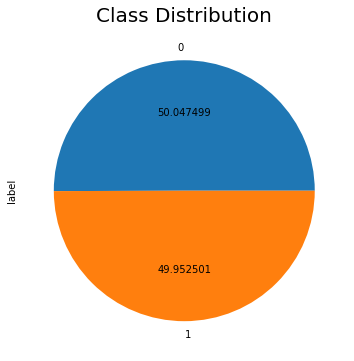

In [6]:
data['label'].value_counts().plot(kind='pie',figsize=(12,6),autopct="%f")
plt.title('Class Distribution',fontsize=20)
plt.show()

In [7]:
# The distribution is unbiased since the ratio of both the classes is approximately 1:1

In [8]:
# wordcloud of reviews with sentiment -> Positive (label 1)

def get_visuals(df,column_name,value):
    s=','
    for element in df[df[column_name]==value]['text']:
        s+=str(element)
    
    wordcloud=WordCloud(background_color='white',
                    random_state=101,
                   width=800,
                   height=800).generate(s)
    
    plt.figure(figsize=(12,8))
    plt.axis('off')
    plt.grid(False)
    plt.imshow(wordcloud)
    plt.show()
    

### Positive Sentiment

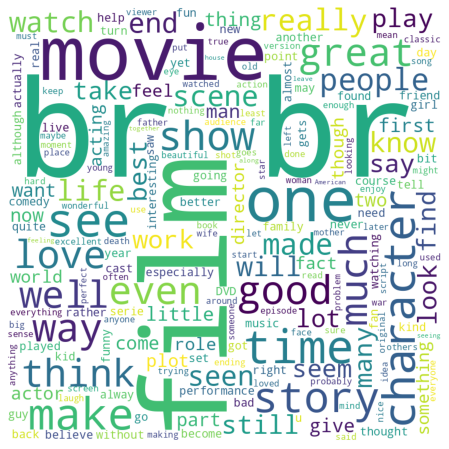

In [9]:
get_visuals(data,'label',1)

### Negative Sentiment

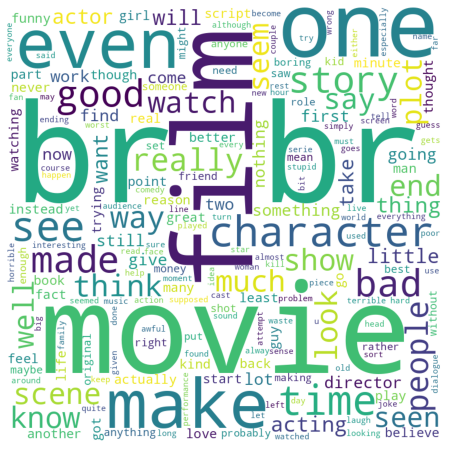

In [10]:
get_visuals(data,'label',0)

## Text Preprocessing

Making a subset of the dataset because of time and computational constraints.

In [11]:
pos_rev=data[data['label']==1][:5000]
neg_rev=data[data['label']==0][:5000]

new_data=pd.concat([pos_rev,neg_rev],axis=0)
new_data.head()

,text,label
4,Im a die hard Dads Army fan and nothing will e...,1
6,Finally watched this shocking movie last night...,1
8,It may be the remake of 1987 Autumn's Tale aft...,1
9,My Super Ex Girlfriend turned out to be a plea...,1
10,I can't believe people are looking for a plot ...,1


In [12]:
# shuffling dataset to get unbiased results.
final_data=new_data.sample(frac=1)
final_data.head()

,text,label
6875,"""The Ex-Mrs. Bradford"" (1936), starring Thin M...",1
5614,"I've tried to like this film, really. In watch...",0
4720,MST 3000 should do this movie. It is the worst...,0
7634,It's so rare to find a film that provides a pl...,1
942,"As I was watching it, I was getting ready to c...",0


In [13]:
new_data['label'].value_counts()

1    5000
0    5000
Name: label, dtype: int64

In [14]:
final_data['label'].value_counts()

1    5000
0    5000
Name: label, dtype: int64

In [15]:
# the dataset is proper

### Text Preprocessing

In [16]:
def prepare_data(df,column_name):
    data=df[column_name]
    useless_words=list(stopwords.words('english')+list(punctuation)+['<br />'])
    
    lemmatizer=WordNetLemmatizer()
    corpus=data.tolist()
    final_corpus=[]
    
    for i in range(len(corpus)):
        word=word_tokenize(corpus[i].lower())
        word=[
            lemmatizer.lemmatize(y) for y in word if y not in useless_words
        ]
        j=" ".join(word)
        j=re.sub(r'[^\w\s]', " ", j)
        j=re.sub("(^|\W)\d+"," ",j)
        
        final_corpus.append(j)
    
    return final_corpus

In [17]:
final_corpus=prepare_data(final_data,'text')

label_=final_data['label']
train_df={
    'label':label_,
    'content':final_corpus,
}

train_df=pd.DataFrame(train_df)
train_df.head()

,label,content
6875,1,ex mrs bradford starring thin man seri...
5614,0,ve tried like film really watching think g...
4720,0,mst movie worst acted movie ever seen first f...
7634,1,s rare find film provides plot ca n t figured...
942,0,watching getting ready compose blasting lambas...


### TF-IDF Vectorizer

In [18]:
tf=TfidfVectorizer()
vector=tf.fit_transform(train_df['content'])
x=vector.toarray()
y=train_df['label']

x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Train-Test Split

In [19]:
X_train,X_test,Y_train,Y_test=train_test_split(x,y,test_size=0.2,random_state=101)

## Machine Learning Models

In [20]:
model_names=['Multinomial Naive Bayes','Logistic Regression']
model=[MultinomialNB(),LogisticRegression()]

def get_results(model_names,model,x_train,x_test,y_train,y_test):
    
    
    model_accuracy_score=[]
    model_auc_score=[]
    
    for i in model:
        model_=i.fit(x_train,y_train)
        y_preds=model_.predict(x_test)
        
        score1=accuracy_score(y_test,y_preds)
        score2=roc_auc_score(y_test,y_preds,)
        
        model_accuracy_score.append(score1)
        model_auc_score.append(score2)
    
    result={
        'Model':model_names,
        'AUC Score': model_auc_score,
        'Accuracy Score': model_accuracy_score
    }
    
    result=pd.DataFrame(result)
    
    return result

### Results and Comparision

In [21]:
comp_df=get_results(model_names,model,X_train,X_test,Y_train,Y_test)

In [22]:
comp_df

,Model,AUC Score,Accuracy Score
0,Multinomial Naive Bayes,0.848880,0.848
1,Logistic Regression,0.879934,0.880


In [23]:
# Logistic Regression gives better results.

## Deep Learning Models

### LSTM Model

In [25]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train_df['content'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 47248 unique tokens.


In [26]:
X = tokenizer.texts_to_sequences(train_df['content'].values)
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (10000, 250)


In [27]:
Y = pd.get_dummies(train_df['label']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (10000, 2)


In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 101)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(8000, 250) (8000, 2)
(2000, 250) (2000, 2)


In [29]:
model = keras.Sequential()
model.add(keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(keras.layers.SpatialDropout1D(0.2))
model.add(keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(keras.layers.Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Model Architecture

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 2)                 202       
Total params: 5,080,602
Trainable params: 5,080,602
Non-trainable params: 0
_________________________________________________________________


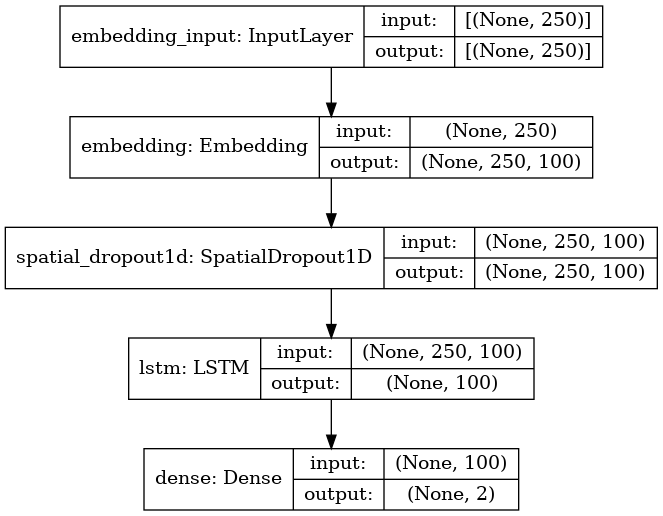

In [31]:
plot_model(model,show_shapes=True,show_layer_names=True)

In [34]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs,steps_per_epoch=100, batch_size=batch_size,validation_split=0.2)

Epoch 1/5
100/100 [==============================] - 41s 414ms/step - loss: 0.4272 - accuracy: 0.8125 - val_loss: 0.3200 - val_accuracy: 0.8537
Epoch 2/5
100/100 [==============================] - 42s 416ms/step - loss: 0.1434 - accuracy: 0.9509 - val_loss: 0.3828 - val_accuracy: 0.8631
Epoch 3/5
100/100 [==============================] - 41s 407ms/step - loss: 0.0460 - accuracy: 0.9869 - val_loss: 0.4577 - val_accuracy: 0.8469
Epoch 4/5
100/100 [==============================] - 42s 415ms/step - loss: 0.0357 - accuracy: 0.9898 - val_loss: 0.5512 - val_accuracy: 0.8400
Epoch 5/5
100/100 [==============================] - 41s 411ms/step - loss: 0.0124 - accuracy: 0.9970 - val_loss: 0.7203 - val_accuracy: 0.8450


### Model Evaluation

In [35]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

63/63 [==============================] - 4s 58ms/step - loss: 0.6577 - accuracy: 0.8500
Test set
  Loss: 0.658
  Accuracy: 0.850


In [36]:
def get_plot(trained_model,no_epochs):
    accuracy=trained_model.history['accuracy']
    loss=trained_model.history['loss']
    val_accuracy=trained_model.history['val_accuracy']
    val_loss=trained_model.history['val_loss']
    epochs=[i for i in range(1,no_epochs+1)]

    plt.figure(figsize=(12,8))
    plt.plot(epochs,accuracy,'r',label='Training')
    plt.plot(epochs,val_accuracy,'--',label='Validation')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy',fontsize=15)
    plt.grid()
    plt.show()

    plt.figure(figsize=(12,8))
    plt.plot(epochs,loss,'r',label='Training')
    plt.plot(epochs,val_loss,'--',label='Validation')
    plt.legend()
    plt.title('Loss',fontsize=15)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.show()

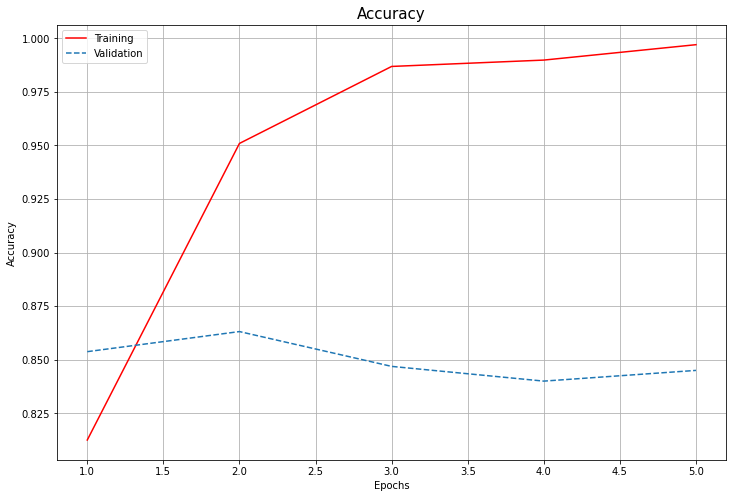

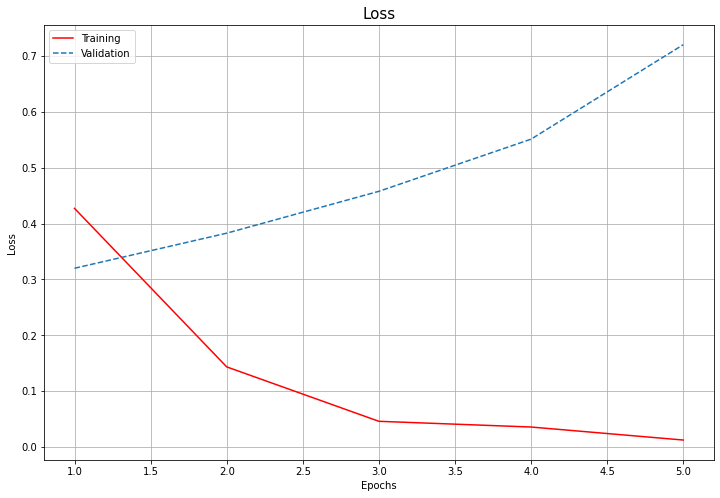

In [37]:
get_plot(history,5)

### Inference
<hr>
Logistic Regression -> 88% accuracy <br>
MultinomialNB -> 84.8% accuracy<br>
LSTM Model -> 85% accuracy<br>
<hr>

Overfitting for the LSTM model can be solved by <ul>
    <li>Decreasing Complexity</li>
    <li>Increasing Dataset</li>
    <li>Adding Regularization Techniques (like batch normalization)</li>
</ul>